In [5]:
from IPython import embed
import numpy as np
from pathlib import Path
from astropy.io import fits
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata, interpn
from astrometry import run_astrometry
from loess.loess_2d import loess_2d

from old_fits_convenience_class import Fits_Simple


# import os
# import sys
# current_dir = os.path.dirname(os.path.abspath(__file__))
# parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# sys.path.append(parent_dir)
# from fits_convenience_class import Fits_Simple


# reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
# directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
# graph_topographic(directories, condition_tuples=conditions_06_26)


def get_errors(image, error_type='error'):
    try:
        with fits.open(image) as hdul:
            # Assuming the table is in the first extension
            data = hdul[1].data
            data = data[data['match_weight'] > 0.99]
            
            x_error = data['field_x'] - data['index_x']
            y_error = data['field_y'] - data['index_y']
            error = np.sqrt(x_error**2 + y_error**2)
        
        if error_type == 'error':
            return np.array(data['field_x']), np.array(data['field_y']), np.array(error)
        elif error_type == 'y':
            return np.array(data['field_x']), np.array(data['field_y']), np.array(y_error)
        elif error_type == 'x':
            return np.array(data['field_x']), np.array(data['field_y']), np.array(x_error)
    except OSError:
        print("Astrometry.net could not solve this image")
        return np.array([]), np.array([]), np.array([])

def single_graph_topographic(directories, files=None, title="", error_type='error',
                      fit_type='loess', frac=0.5):
    
    images = unzip_directories(directories, files, output_format='Path')
    
    if files is not None:
        output_dir = str(Path(files[0]).parent.parent.parent / 'astrometric')
    else:
        output_dir = str(Path(directories[0]).parent.parent / 'astrometric')
    
    astro_calib_images = run_astrometry(images, output_dir, mode='corr')
    print(astro_calib_images)
    
    # Collect all coordinates and FWHMs in numpy arrays
    all_x, all_y, all_errors = zip(*(get_errors(image, error_type) 
                                        for image in astro_calib_images))
    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)
    all_errors = np.concatenate(all_errors)
    
    # Create grid for interpolation
    grid_x, grid_y = np.mgrid[0:1024:3, 0:1024:3]
    
    if fit_type == 'loess':
        # Interpolate data using Loess smoothing - computationally difficult
        print('loess_2d beginning')
        flat_z, wout = loess_2d(all_x, all_y, all_errors, xnew=grid_x.flatten(),
                        ynew=grid_y.flatten(), frac=frac)
        print('loess_2d done')
        grid_z = flat_z.reshape(grid_x.shape)
    else:
        # Interpolate data - griddata
        grid_z = griddata((all_x, all_y), all_errors, (grid_x, grid_y), method=fit_type)
    
    
    # cmap = plt.get_cmap('terrain')
    # Define the color & range of contour levels
    colors = ["#cc0018", "#cd0000", "#cb4000", "#c97f00", "#c7bc00", "#91c400", "#52c200", 
              "#00bc62", "#00ba9c", "#009cb8", "#0061b6", "#1100b1", "#4800af", "#7e00ad"]
    if fit_type == 'loess' and error_type == 'error':
        levels = np.linspace(0, 1.3, len(colors))
    elif error_type == 'error':
        levels = np.linspace(0, 4.0, len(colors))
    else:
        levels = np.linspace(-2.0, 2.0, len(colors))
    
    # colors = ["#b70000", "#b64d00", "#b59a00", "#82b300", "#00b117", 
    #           "#00afab", "#0067ae", "#001dac", "#2c00ab", "#7400aa"]

    # Create a Normalize object with the desired range
    # norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256, clip=True)
    
    # Plot contour map
    plt.figure()
    cp = plt.contourf(grid_x, grid_y, grid_z, levels=levels, colors=colors,)
    plt.colorbar(cp)
    plt.title(f'Astrometric Residuals Contour Map ({error_type}) - {title}')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()
    

def graph_topographic(directories, condition_tuples, files=None, error_type='error',
                      fit_type='loess', frac=0.5):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    categories = categories_from_conditions(condition_tuples, images)
    
    for category, file_list in categories.items():
        single_graph_topographic(None, files=file_list, title=category, 
                                 error_type=error_type, fit_type=fit_type,
                                 frac=frac)


def categories_from_conditions(condition_tuples, images):
    # Initialize an empty dictionary
    conditions = {}
    # Process the input list
    for value, (start, end) in condition_tuples:
        if value in conditions:
            conditions[value].append((start, end))
        else:
            conditions[value] = [(start, end)]

    # Convert ranges to lambda functions
    conditions = {width: (lambda ranges: lambda img_num: any(start <= img_num <= end for start, end in ranges))(ranges) for width, ranges in conditions.items()}
    # Use dictionary comprehension to create the categories
    categories = {width: [file.path for file in images if condition(file.image_num)] for width, condition in conditions.items()}
    return categories


def unzip_directories(directories, files=None, output_format='Fits_Simple'):
    if output_format == 'Path':
        output = Path
    elif output_format == 'Fits_Simple':
        output = Fits_Simple
    
    if files is not None:
        images = [output(file) for file in files]
    else:
        if not isinstance(directories, list):
            directories = [directories,]
        images = []
        for dir in directories:
            images += [output(file) for file in Path(dir).iterdir()]
    return images


conditions_06_26 = [(1.375, (65, 74)),
                    (1.625, (22, 31)),
                    (1.625, (88, 105)),
                    (1.875, (33, 42)),
                    (2.625, (43, 53)),
                    (3.375, (54, 64)),
                    ]


ModuleNotFoundError: No module named 'astrometry'

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1026_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1027_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1102_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1103_red_corr.fits']


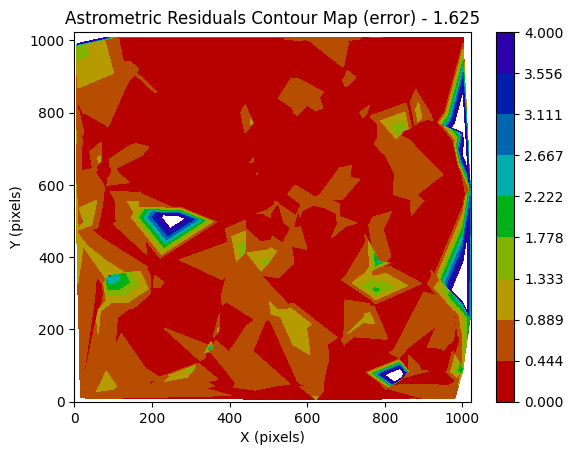

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1040_red_corr.fits']


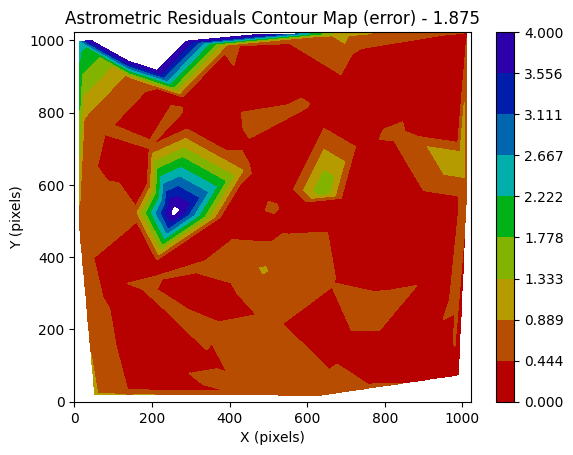

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1051_red_corr.fits']


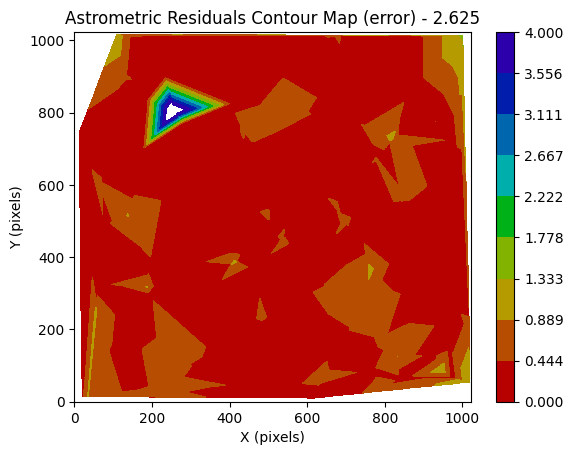

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1062_red_corr.fits']


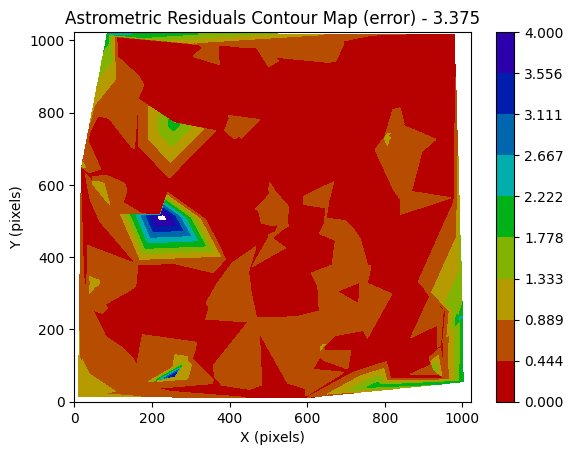

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1072_red_corr.fits']


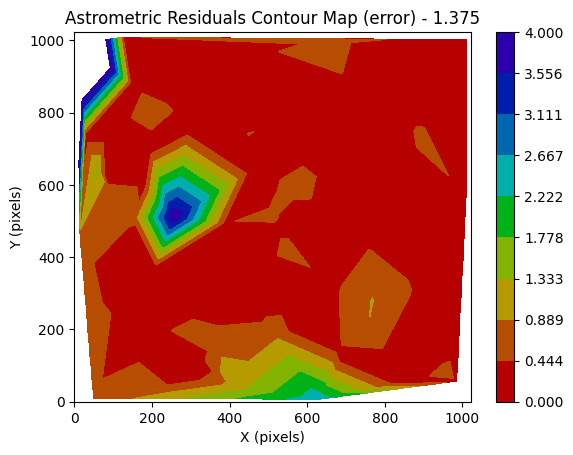

In [ ]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, error_type='error', fit_type='griddata')

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1026_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1027_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1102_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1103_red_corr.fits']


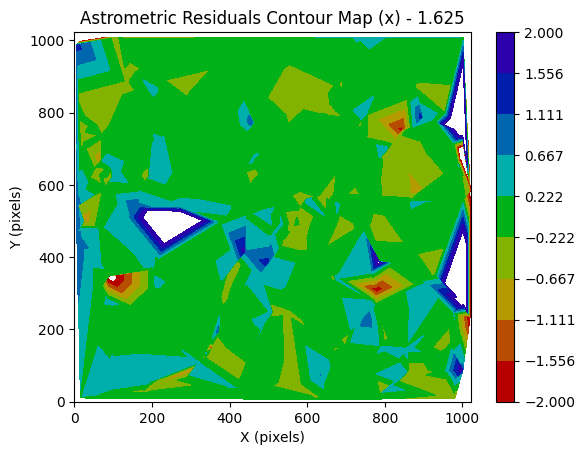

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1040_red_corr.fits']


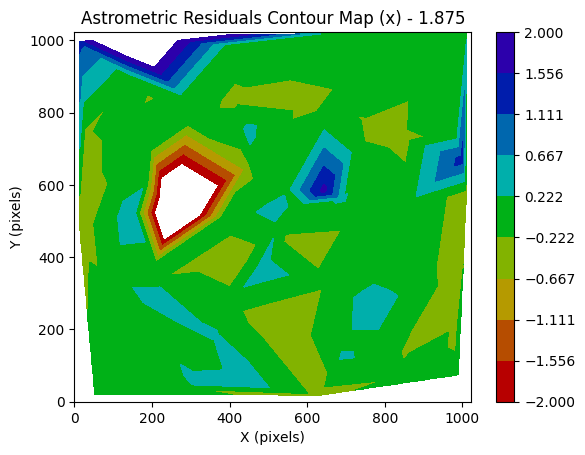

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1051_red_corr.fits']


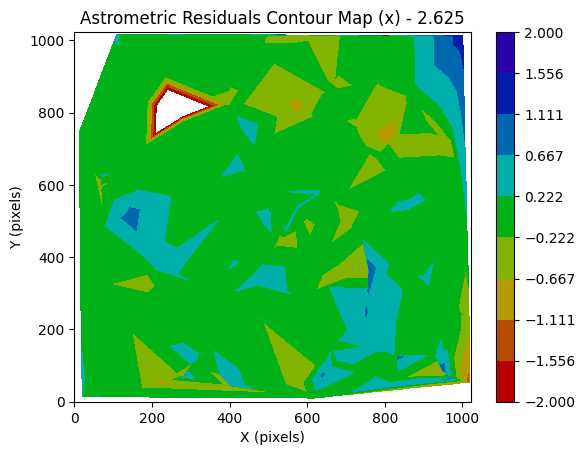

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1062_red_corr.fits']


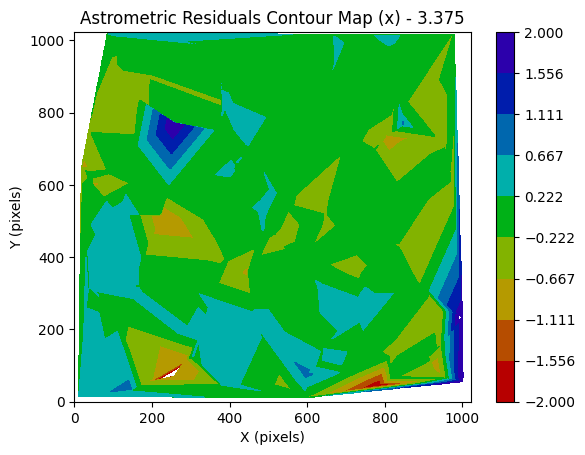

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1072_red_corr.fits']


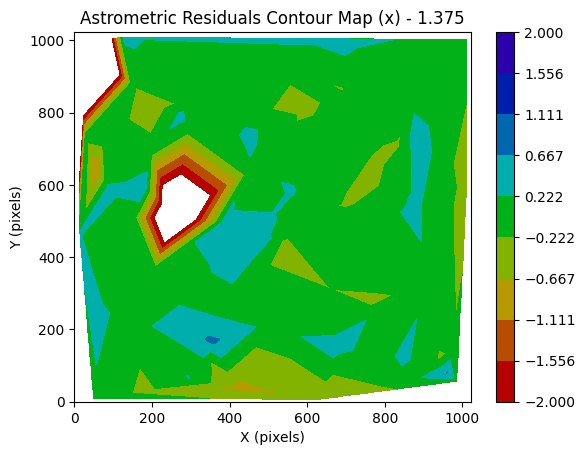

In [ ]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, error_type='x', fit_type='griddata')

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1026_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1027_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1102_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1103_red_corr.fits']


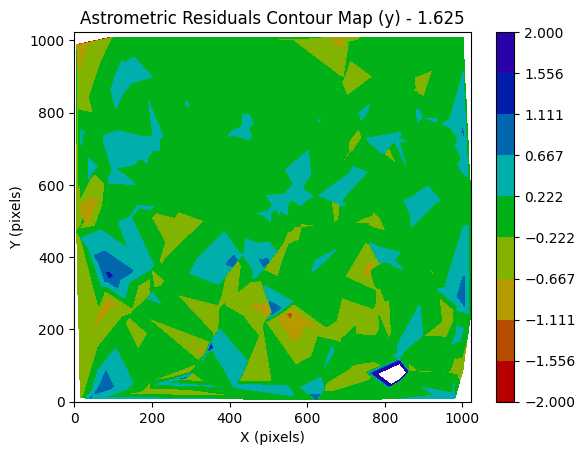

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1040_red_corr.fits']


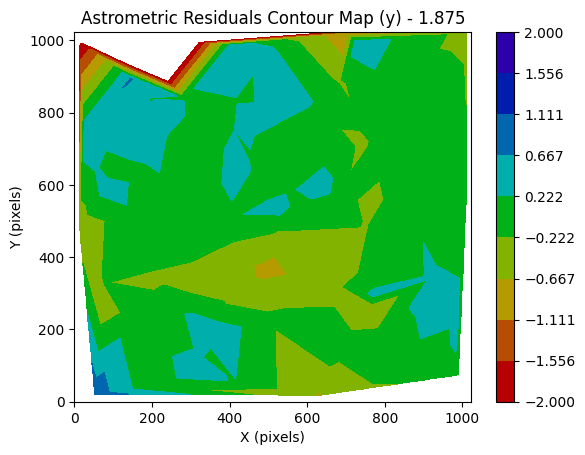

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1051_red_corr.fits']


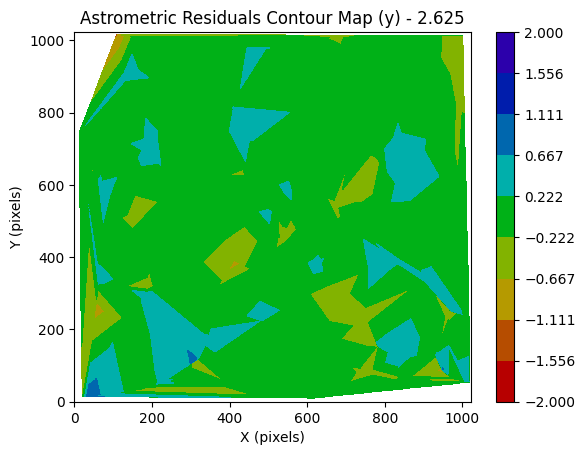

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1062_red_corr.fits']


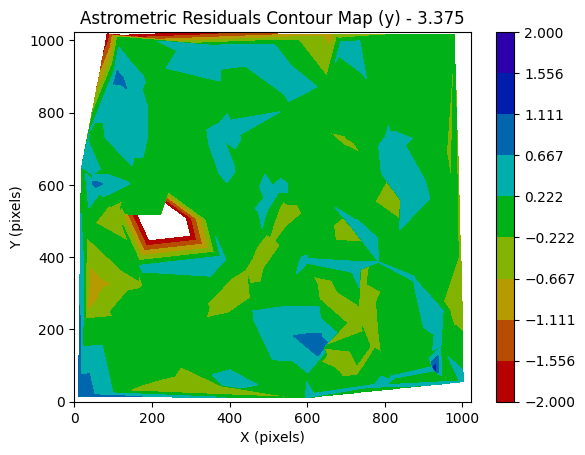

Connecting to astrometry.net
['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\raw-astrometric\\d1072_red_corr.fits']


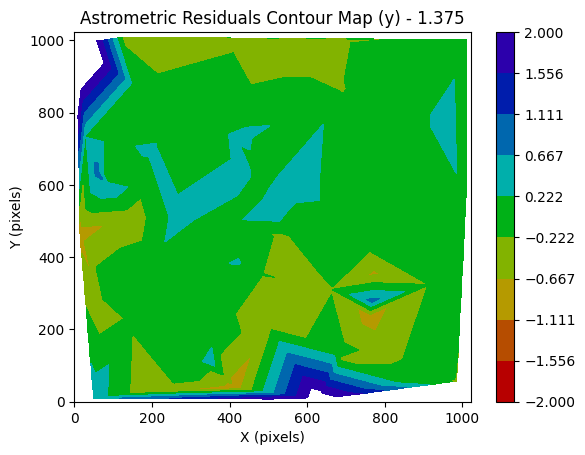

In [ ]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, error_type='y', fit_type='griddata')

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1072_red_corr.fits']
loess_2d beginning
loess_2d done


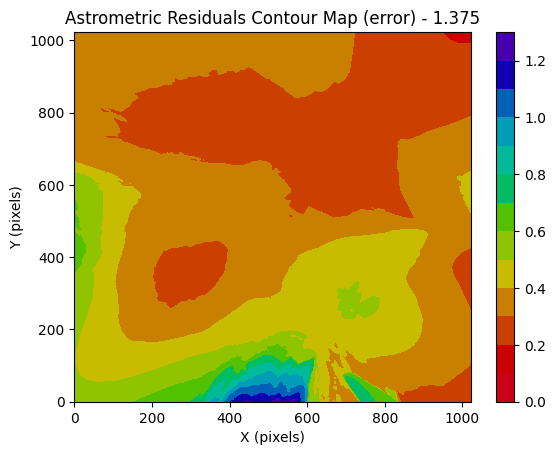

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1022_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1023_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1098_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1099_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1025_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1100_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\

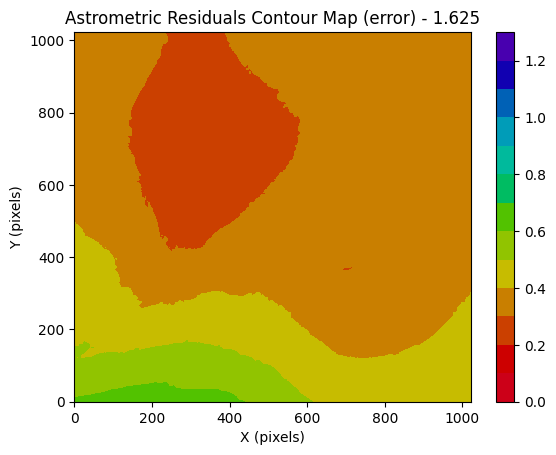

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1040_red_corr.fits']
loess_2d beginning
loess_2d done


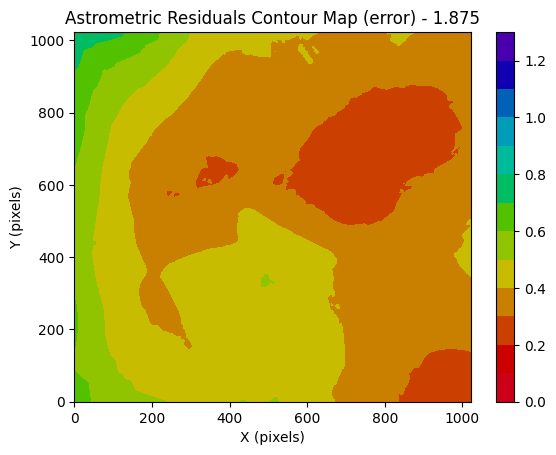

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1051_red_corr.fits']
loess_2d beginning
loess_2d done


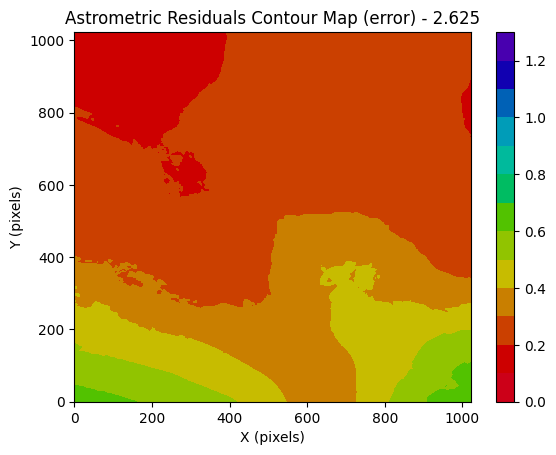

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1062_red_corr.fits']
loess_2d beginning
loess_2d done


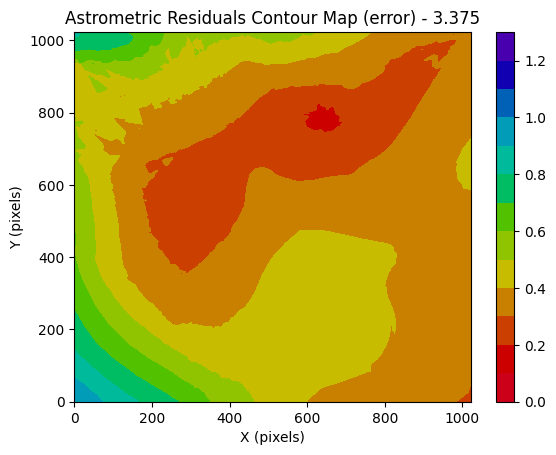

In [7]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 
                                                   'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, 
                  error_type='error', fit_type='loess', frac=0.3)

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1072_red_corr.fits']
loess_2d beginning
loess_2d done


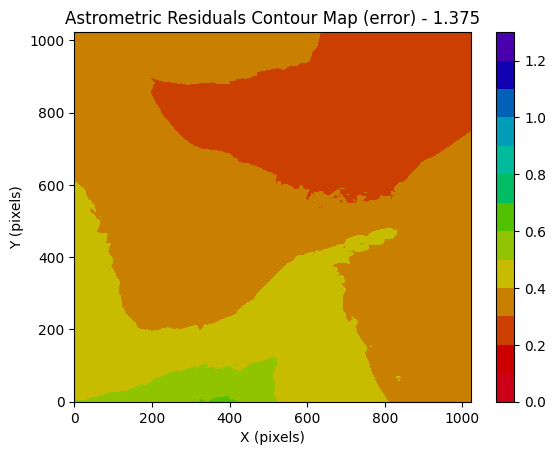

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1022_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1023_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1098_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1099_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1025_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1100_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\

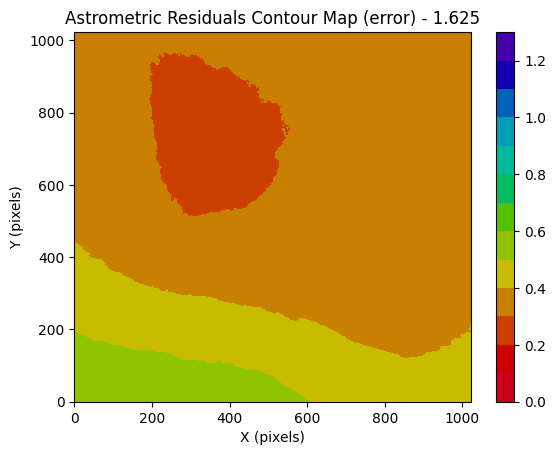

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1040_red_corr.fits']
loess_2d beginning
loess_2d done


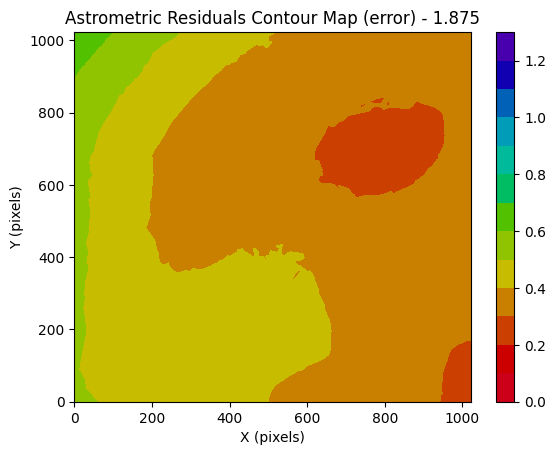

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1051_red_corr.fits']
loess_2d beginning
loess_2d done


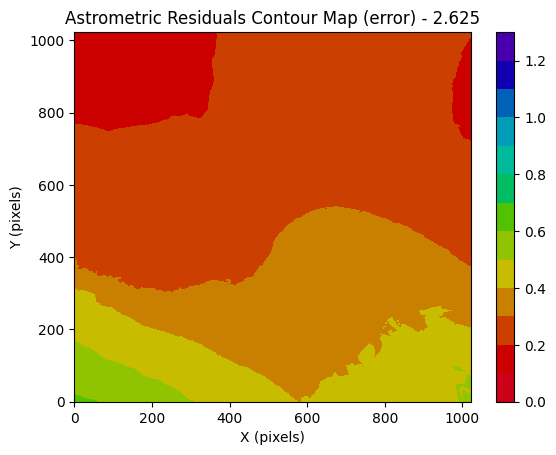

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1062_red_corr.fits']
loess_2d beginning
loess_2d done


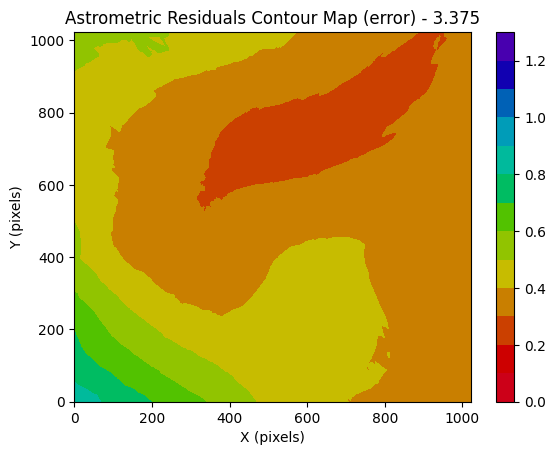

In [8]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 
                                                   'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, 
                  error_type='error', fit_type='loess', frac=0.5)

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1072_red_corr.fits']
loess_2d beginning
loess_2d done


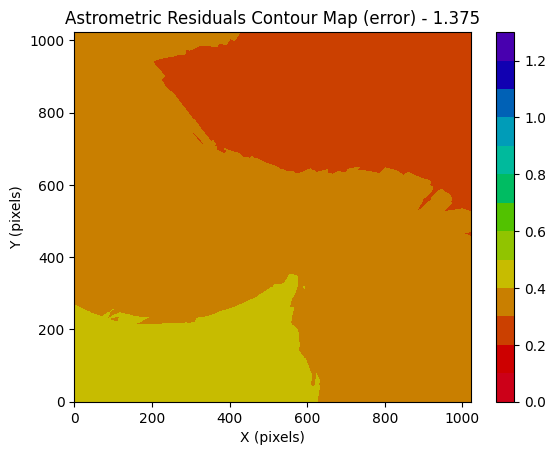

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1022_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1023_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1098_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1099_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1024_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1025_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1100_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\

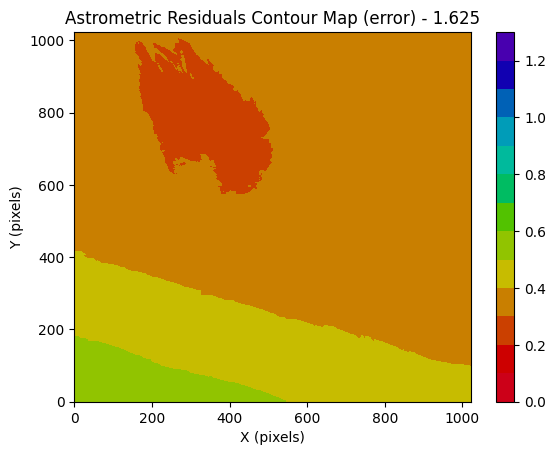

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1040_red_corr.fits']
loess_2d beginning
loess_2d done


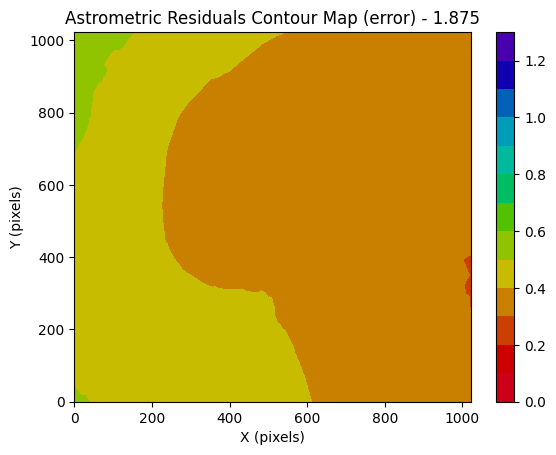

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1048_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1049_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1050_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1051_red_corr.fits']
loess_2d beginning
loess_2d done


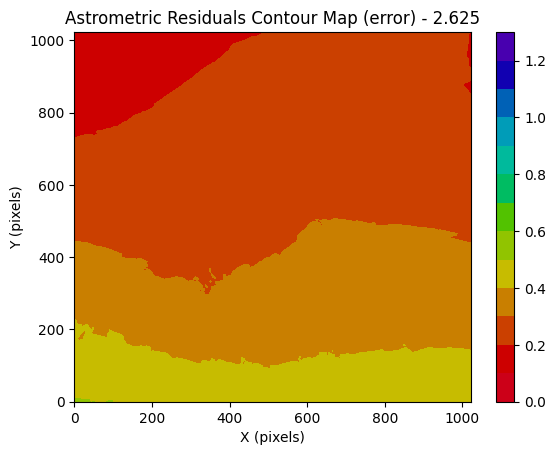

['C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1060_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1061_red_corr.fits', 'C:\\Users\\allis\\Documents\\2024-2025_Local\\Akamai Internship\\pipeline-testing\\test-data-06-26\\astrometric\\d1062_red_corr.fits']
loess_2d beginning
loess_2d done


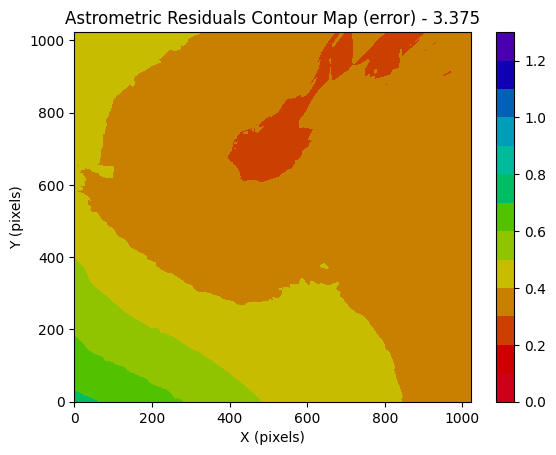

In [9]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 
                                                   'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, 
                  error_type='error', fit_type='loess', frac=0.7)